<a href="https://colab.research.google.com/github/imemmul/Food_classification_EfficientNetB4/blob/main/food_classification_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### My first attempt was a little bit unsuccessful so now I am going to try to use all things that I've got

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-831672c8-d77a-b0ac-981c-fbcf26d32664)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-02 10:56:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-02 10:56:56 (78.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import plot_loss_curves, compare_historys, create_tensorboard_callback

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTUVF65/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTUVF65/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
len(train_data)

75750

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

#### We have 101 different food types to train

In [8]:
class_names = ds_info.features["label"].names
#adding classes to a variable

In [9]:
train_data_sample_1 = train_data.take(5)

In [10]:
train_data_sample_1

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for image, label in train_data_sample_1:
  print(f"""
    Image Shape: {image.shape}
    Image datatype: {image.dtype}
    Target Class: {label}
    class name: {class_names[int(label)]}
  """)


    Image Shape: (384, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 97
    class name: takoyaki
  

    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 25
    class name: club_sandwich
  

    Image Shape: (512, 384, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 80
    class name: pulled_pork_sandwich
  

    Image Shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 71
    class name: paella
  

    Image Shape: (384, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 32
    class name: dumplings
  


Upper print shows us that our data not one-hot encoded so should consider "Sparse" while compiling our model.

In [12]:
import tensorflow as tf

(-0.5, 511.5, 383.5, -0.5)

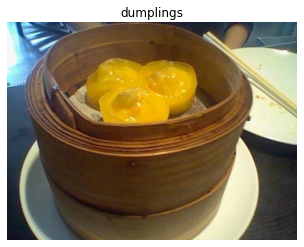

In [13]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[int(label)])
plt.axis(False)

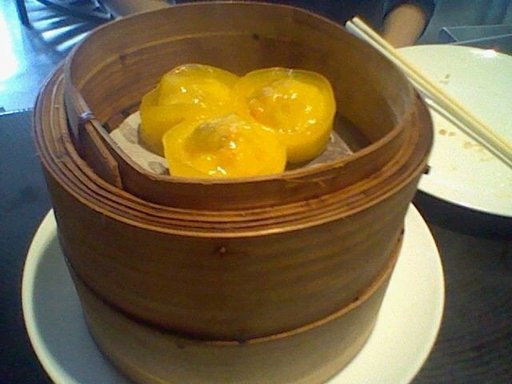

In [14]:
tf.keras.utils.array_to_img(image)

In [15]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [16]:
pre_img = preprocess_img(image, label)[0]
pre_img.shape

TensorShape([224, 224, 3])

## Batching dataset

In [17]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

#shuffle train_data to batch

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
len(train_data)

2368

In [20]:
74*32

2368

### Creating callbacks

In [21]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [22]:
tf.__version__

'2.8.2'

## Researching Mixed precision training

In [23]:
from tensorflow.keras import mixed_precision

In [24]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [25]:
policy.variable_dtype

'float32'

In [26]:
!nvidia-smi

Fri Sep  2 11:05:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
# x = preprocessing.Rescale(1./255)(x) if you are using a application without scaling use this line
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="float32_layer")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [29]:
 model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 float32_layer (Activation)  (None, 101)               0         
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
___________________________________________

In [31]:
for layer in model.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_layer float32 <Policy "float32">
efficientnetb4 float32 <Policy "mixed_float16">
global_average_pooling2d_1 float32 <Policy "mixed_float16">
dense_1 float32 <Policy "mixed_float16">
float32_layer float32 <Policy "float32">


In [36]:
for layer in model.layers[1].layers:
  if layer.dtype_policy.name != "mixed_float16":
    print(layer.name, " ", layer.trainable, " ", layer.dtype_policy)

input_2   False   <Policy "float32">


Except input_layer the all layers are in mixed precision effect

#### Fitting the model

In [37]:
history_1 = model.fit(train_data,
                      validation_data=test_data,
                      epochs=3,
                      validation_steps=int(0.10*len(test_data)),
                      steps_per_epoch=len(train_data),
                      callbacks=[create_tensorboard_callback(dir_name="training_big",
                                                             experiment_name="efficientnetb4"),
                                 model_checkpoint])

Saving TensorBoard log files to: training_big/efficientnetb4/20220902-113317
Epoch 1/3
2368/2368 [==============================] - 306s 118ms/step - loss: 1.8717 - accuracy: 0.5373 - val_loss: 1.3370 - val_accuracy: 0.6547
Epoch 2/3
2368/2368 [==============================] - 282s 118ms/step - loss: 1.3878 - accuracy: 0.6396 - val_loss: 1.2365 - val_accuracy: 0.6677
Epoch 3/3
2368/2368 [==============================] - 286s 120ms/step - loss: 1.2388 - accuracy: 0.6743 - val_loss: 1.2002 - val_accuracy: 0.6768


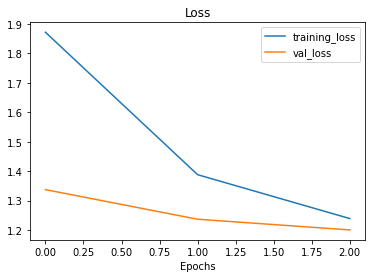

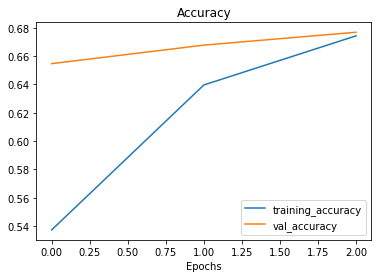

In [38]:
plot_loss_curves(history_1)

In [39]:
model.evaluate(test_data)

790/790 [==============================] - 86s 108ms/step - loss: 1.2002 - accuracy: 0.6761


[1.200167179107666, 0.6760792136192322]